In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools


# Get Data 
---

In [2]:
prices = pd.read_csv("binance_data/L1/2024/1h/merged_L1_closing_prices.csv", index_col=0, parse_dates=True)

# Applly funnel and test for cointegration
---

In [3]:

# Pre-filter: Calculate correlation matrix and select pairs with high correlation
corr_threshold = 0.8
corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
print(f"\nPairs with correlation >= {corr_threshold}:")
for pair in high_corr_pairs:
    print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# Cointegration test
cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)
#cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=720, min_pass_fraction=0.5)



Pairs with correlation >= 0.8:
SUI/USDT_2024_1h & TRX/USDT_2024_1h: correlation = 0.8638
SUI/USDT_2024_1h & BTC/USDT_2024_1h: correlation = 0.8064
SUI/USDT_2024_1h & ADA/USDT_2024_1h: correlation = 0.8063
ICP/USDT_2024_1h & AVAX/USDT_2024_1h: correlation = 0.8502
BNB/USDT_2024_1h & BTC/USDT_2024_1h: correlation = 0.8325
BNB/USDT_2024_1h & SOL/USDT_2024_1h: correlation = 0.8265
BTC/USDT_2024_1h & SOL/USDT_2024_1h: correlation = 0.9251

Cointegrated pairs (from pre-filtered high-correlation pairs):
ICP/USDT_2024_1h & AVAX/USDT_2024_1h: p-value = 0.0484, correlation = 0.8502


In [4]:
# window_results

In [5]:
pvalue_matrix

,SUI/USDT_2024_1h,NEAR/USDT_2024_1h,ICP/USDT_2024_1h,TRX/USDT_2024_1h,BNB/USDT_2024_1h,BTC/USDT_2024_1h,AVAX/USDT_2024_1h,ETH/USDT_2024_1h,SOL/USDT_2024_1h,ADA/USDT_2024_1h
SUI/USDT_2024_1h,1.000000,1.0,1.000000,0.078351,1.000000,0.731393,1.000000,1.0,1.000000,0.665781
NEAR/USDT_2024_1h,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
ICP/USDT_2024_1h,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.048387,1.0,1.000000,1.000000
TRX/USDT_2024_1h,0.078351,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
BNB/USDT_2024_1h,1.000000,1.0,1.000000,1.000000,1.000000,0.420524,1.000000,1.0,0.239847,1.000000
BTC/USDT_2024_1h,0.731393,1.0,1.000000,1.000000,0.420524,1.000000,1.000000,1.0,0.271896,1.000000
AVAX/USDT_2024_1h,1.000000,1.0,0.048387,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
ETH/USDT_2024_1h,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
SOL/USDT_2024_1h,1.000000,1.0,1.000000,1.000000,0.239847,0.271896,1.000000,1.0,1.000000,1.000000
ADA/USDT_2024_1h,0.665781,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [6]:
# cointegrated_pairs = [('BNB/USDT_2024_1h',
#   'BTC/USDT_2024_1h',
#   0.731393,
#   0.8501886494196308)]

In [7]:
#If you suspect daily intraday patterns, using 24 lags is a natural choice: it checks each hour in a 24-hour cycle for dependence.
#If your sample is large enough (covering many days/weeks), 24 lags is typically enough to detect standard intraday correlation
analyze_residuals(residuals_df, lags = 24)

P-value for Ljung-Box test for pair ICP/USDT_2024_1h_AVAX/USDT_2024_1h: 0.9791634198680497
Residuals of pair ICP/USDT_2024_1h_AVAX/USDT_2024_1h are likely white noise (independent).


In [8]:
cointegrated_pairs

[('ICP/USDT_2024_1h',
  'AVAX/USDT_2024_1h',
  np.float64(0.04838690015312888),
  np.float64(0.8501886494196308))]

# Test strategy
---

# New Code

In [ ]:
if cointegrated_pairs:
        sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]

        #Only look at the first 1000 points for now
        # S1 = S1[:720]
        # S2 = S2[:720]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series = compute_spread_series(S1, S2, window_size=720)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Generate trading signals based on the spread's z-score
        zscore_series, positions_series = backtest_pair_rolling(spread_series, window_size=720, entry_threshold=1.0, exit_threshold=0.0)
        
        # Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

        pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        
        #Plot trading simulation
        plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, cum_pnl)

## OLD CODE


Testing strategy on pair: ICP/USDT_2024_1h and AVAX/USDT_2024_1h (p-value: 0.0484, correlation: 0.8502)
Hedge ratio (beta) for ICP/USDT_2024_1h ~ AVAX/USDT_2024_1h: 0.2633
Long Entries: 3, Short Entries: 3


/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


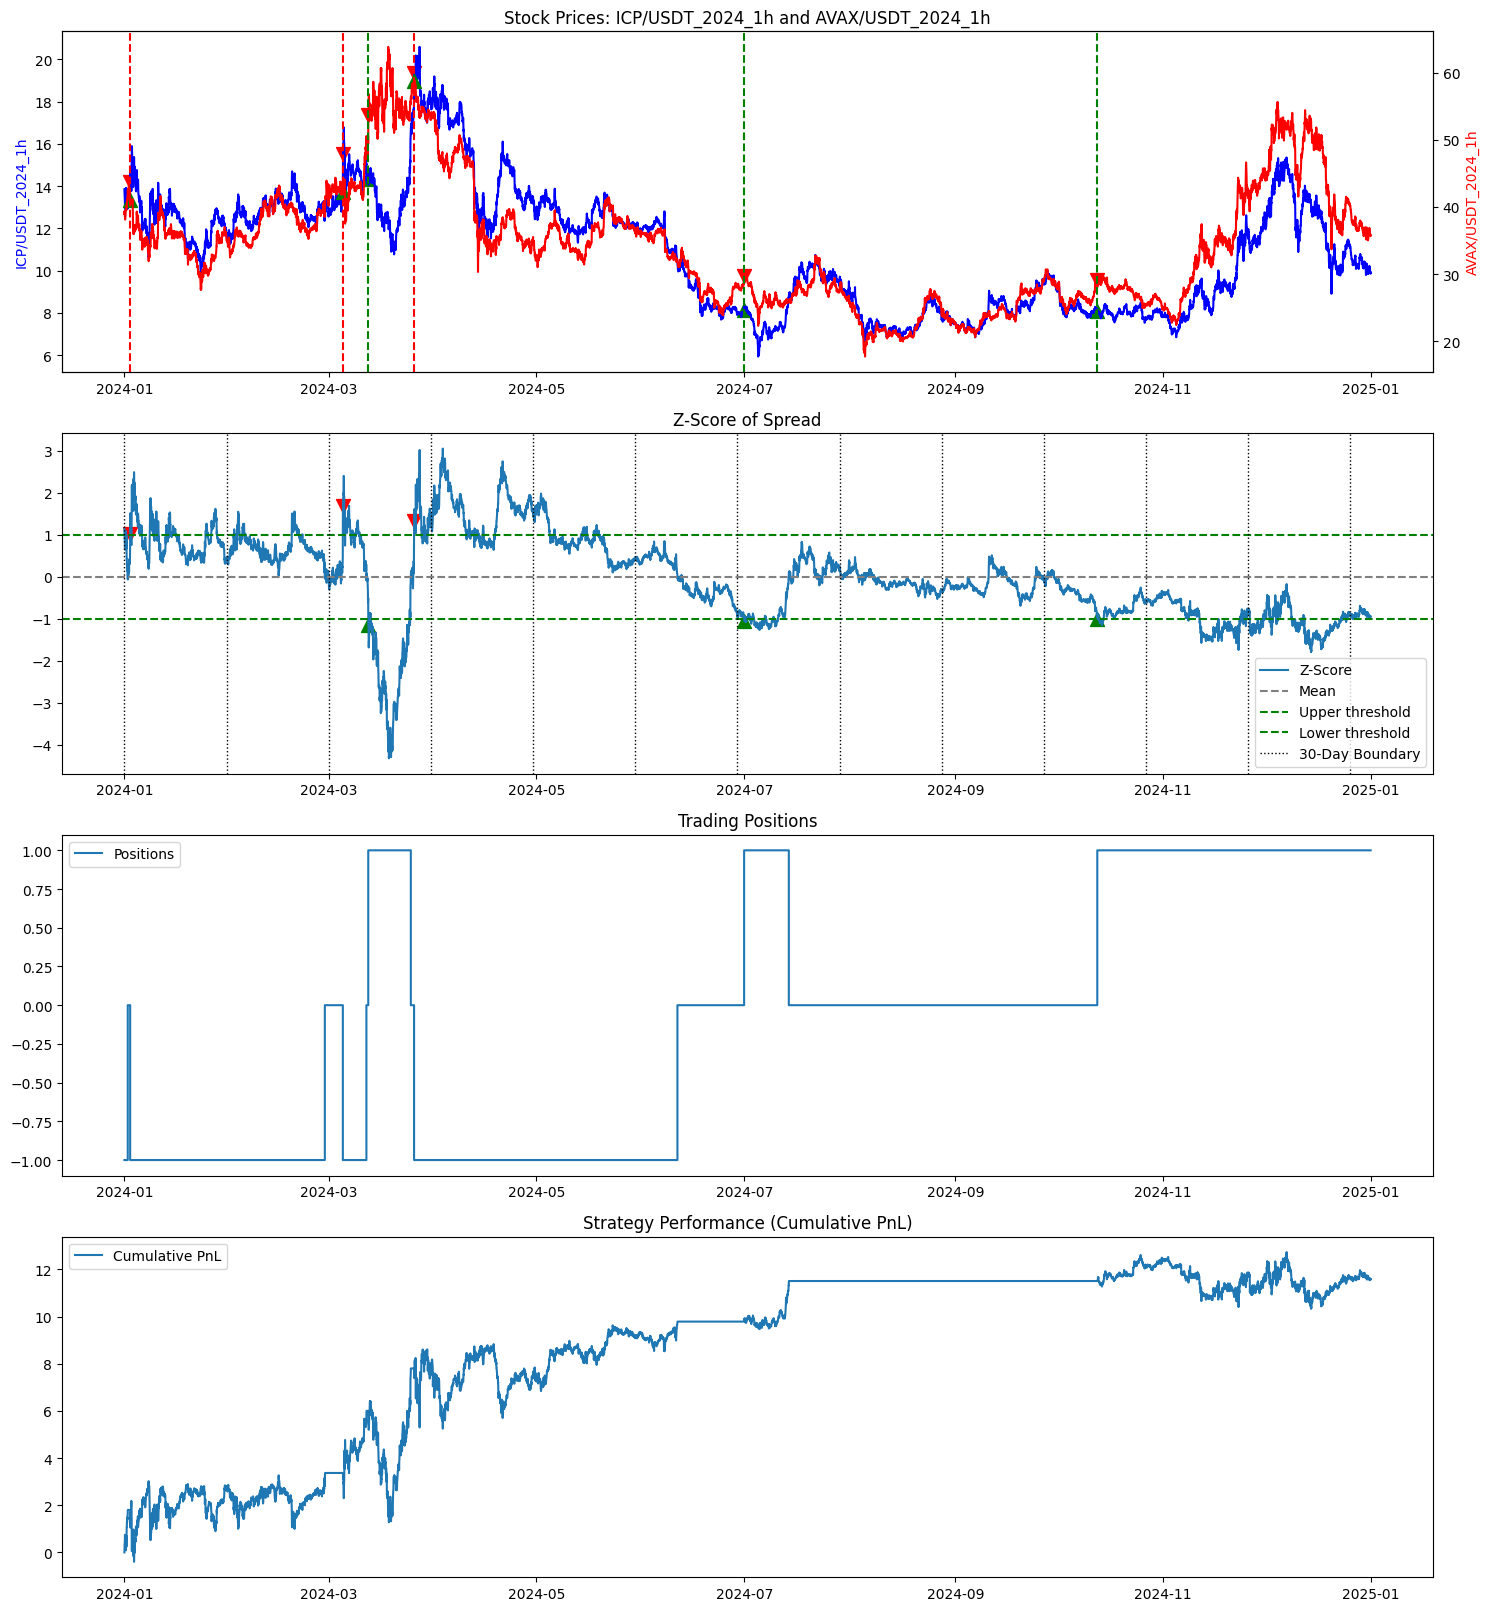

In [9]:
if cointegrated_pairs:
        sym1, sym2, pvalue, corr_val = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (p-value: {pvalue:.4f}, correlation: {corr_val:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]

        #Only look at the first 1000 points for now
        # S1 = S1[:720]
        # S2 = S2[:720]
        
        # Compute the spread and hedge ratio
        spread, beta = compute_spread(S1, S2)
        print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Generate trading signals based on the spread's z-score
        zscore, positions = backtest_pair(spread, entry_threshold=1, exit_threshold=0.0)
        
        # Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

        pnl, cum_pnl = simulate_true_strategy(S1, S2, positions, beta)
        
        #Plot trading simulation
        plot_trading_simulation(S1, S2, sym1,sym2,zscore, positions, cum_pnl)

In [10]:
spread_series, beta_series = compute_spread_series(S1, S2, window_size=720)

/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_t = model.params[1]
/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_t = model.params[1]
/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/back_tester.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_t = model.params[1]
/

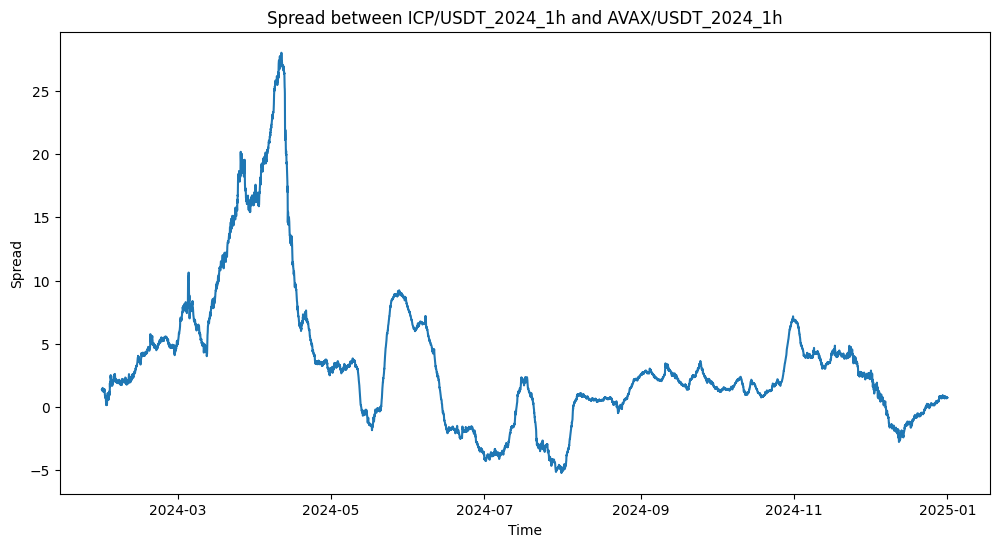

In [14]:
#Plot spread series
plt.figure(figsize=(12,6))
plt.plot(spread_series)
plt.title(f"Spread between {sym1} and {sym2}")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()

In [11]:
zscore_series, roll_mean, roll_std = compute_rolling_zscore(spread_series, window_size=720)

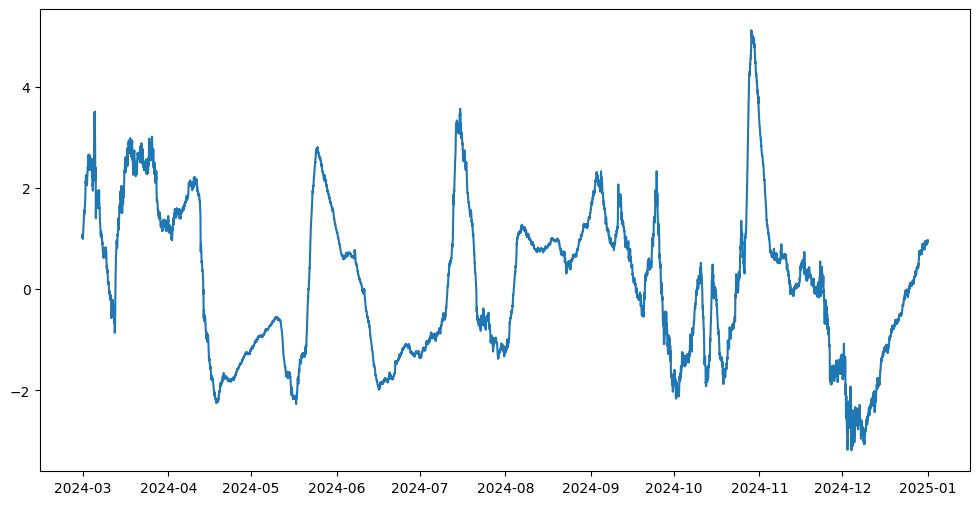

In [18]:
#Plot z-score series
plt.figure(figsize=(12,6))
plt.plot(zscore_series, label="Z-score")

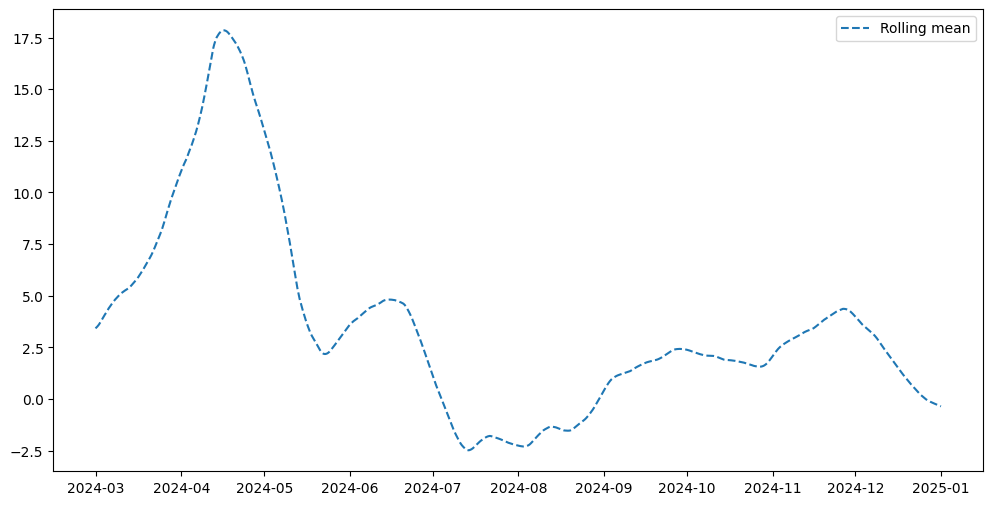

In [22]:
#Plot rolling mean and standard deviation

plt.figure(figsize=(12,6))
plt.plot(roll_mean, label="Rolling mean", linestyle="--")
plt.legend()